In [1]:
import os, os.path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
## Encodes the labels in one hot format
def toOneHot(X):

    z = np.max(X) + 1
    X_oh = np.eye(z)[X]

    return X_oh

In [4]:
# Load and label EMG files
def loadAndLabel(folder_path,w,p):

    # folder_path -> path of the folder that contains each subject subfolder
    # w -> window size
    # p -> moving average delays

    data = [name for name in os.walk(folder_path)]

    X = []
    Y = []

    # Iterates folders
    for i in range(1,len(data)):

        # Iterates files in each folder
        for j in range(0,len(data[i][2])):

            # loads EMG data
            emgData = pd.read_csv(os.path.join(data[i][0], data[i][2][j]), sep='\t', header=None).values

            # Performs segmentation in windows
            for k in range(0,emgData.shape[0] - w + 1,w):

                d = emgData[k:k+w,:]
                d = np.abs(d) # Absolute value of the EMG data
                # Moving average filter for each channel
                for n in range(d.shape[1]-1):
                    d[:,n] = np.convolve(d[:,n], np.ones(p)/p, mode='same')
                X.append(d)

                # Generate labels for each window
                if data[i][2][j].split(".")[0] == '0':
                    Y.append(0)
                elif data[i][2][j].split(".")[0] == '1':
                    Y.append(1)
                elif data[i][2][j].split(".")[0] == '2':
                    Y.append(2)
                elif data[i][2][j].split(".")[0] == '3':
                    Y.append(3)
                elif data[i][2][j].split(".")[0] == '4':
                    Y.append(4)

    X = np.array(X)
    X = X/np.max(X)
    Y = np.array(Y)
    Y = toOneHot(Y)

    return X, Y

In [5]:
path = "/content/drive/MyDrive/EMG hand gestures dataset"
X, Y = loadAndLabel(path,200,20) # Load and label EMG data

In [ ]:
# Split intro training and validation
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y)

In [ ]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32)

# Create datasets and dataloaders
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

In [ ]:
Y_train_tensor = torch.argmax(Y_train_tensor, dim=1)
Y_test_tensor = torch.argmax(Y_test_tensor, dim=1)

In [ ]:
Y_train_tensor = Y_train_tensor.type(torch.FloatTensor)
Y_test_tensor = Y_test_tensor.type(torch.FloatTensor)

In [ ]:
# Define the EMGModel class
class EMGModel(nn.Module):
    def __init__(self):
        super(EMGModel, self).__init__()
        self.fc1 = nn.Linear(800, 32)  # Update input size to 200 * channels (4)
        self.tanh1 = nn.Tanh()
        self.lstm = nn.LSTM(32, 16, batch_first=True)
        self.fc2 = nn.Linear(16, 32)
        self.tanh2 = nn.Tanh()
        self.fc3 = nn.Linear(32, 5)  # Output classes: 5

    def forward(self, x):
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)  # Reshape to (batch_size, 200*channels)
        x = self.tanh1(self.fc1(x))
        x, _ = self.lstm(x)  # Get the output from the LSTM layer
        #x = x[:, -1, :]  # Take the output from the last time step
        x = self.tanh2(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
def validate(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    correct = 0
    with torch.no_grad():  # Disable gradient calculation
        for data, target in test_loader:
            output = model(data)
            loss = criterion(output, target)
            total_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)  # Get predicted class
            actual_class_indices = torch.argmax(target, dim=1)
            correct += pred.eq(actual_class_indices.view_as(pred)).sum().item()

    avg_loss = total_loss / len(test_loader)
    accuracy = 100. * correct / len(test_loader.dataset)
    return avg_loss, accuracy

In [ ]:
# Instantiate the model, optimizer, and loss function
model = EMGModel()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
train_losses = []
val_losses = []
# Training loop
for epoch in range(1000):
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()  # Reset gradients
        output = model(data)  # Forward pass
        loss = criterion(output, target) # Calculate loss, convert target to long
        loss.backward()  # Backpropagate
        optimizer.step()  # Update weights

    # Validation

    val_loss, val_accuracy = validate(model, test_loader, criterion)
    print(f"Epoch {epoch}: Val Loss = {val_loss:.4f}, Val Accuracy = {val_accuracy:.2f}%")

    # Append losses
    train_losses.append(loss.item()) # Append training loss for current batch
    val_losses.append(val_loss)

# Add EMGModel to safe globals
torch.serialization.add_safe_globals([EMGModel])

Epoch 0: Val Loss = 1.5845, Val Accuracy = 20.02%
Epoch 1: Val Loss = 1.5390, Val Accuracy = 23.93%
Epoch 2: Val Loss = 1.4462, Val Accuracy = 46.28%
Epoch 3: Val Loss = 1.2826, Val Accuracy = 59.83%
Epoch 4: Val Loss = 1.1009, Val Accuracy = 63.13%
Epoch 5: Val Loss = 0.9776, Val Accuracy = 66.54%
Epoch 6: Val Loss = 0.8961, Val Accuracy = 68.86%
Epoch 7: Val Loss = 0.8194, Val Accuracy = 72.77%
Epoch 8: Val Loss = 0.7351, Val Accuracy = 73.87%
Epoch 9: Val Loss = 0.6485, Val Accuracy = 76.56%
Epoch 10: Val Loss = 0.5746, Val Accuracy = 79.49%
Epoch 11: Val Loss = 0.5215, Val Accuracy = 80.10%
Epoch 12: Val Loss = 0.4792, Val Accuracy = 81.81%
Epoch 13: Val Loss = 0.4492, Val Accuracy = 83.52%
Epoch 14: Val Loss = 0.4298, Val Accuracy = 83.76%
Epoch 15: Val Loss = 0.4082, Val Accuracy = 84.37%
Epoch 16: Val Loss = 0.3946, Val Accuracy = 84.37%
Epoch 17: Val Loss = 0.3797, Val Accuracy = 85.23%
Epoch 18: Val Loss = 0.3680, Val Accuracy = 85.96%
Epoch 19: Val Loss = 0.3592, Val Accuracy

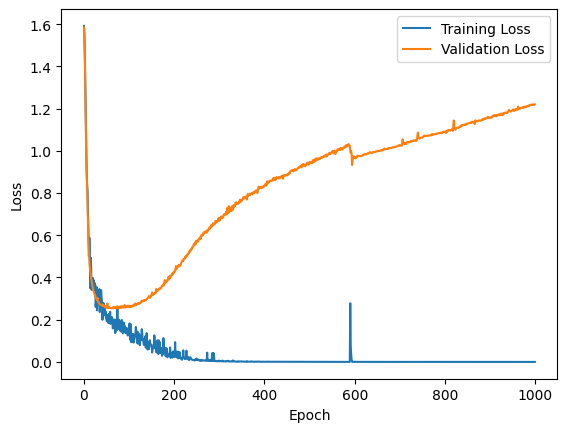

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Epoch 0: Val Loss = 1.5944, Val Accuracy = 25.40%
Epoch 1: Val Loss = 1.5629, Val Accuracy = 20.51%
Epoch 2: Val Loss = 1.4922, Val Accuracy = 35.78%
Epoch 3: Val Loss = 1.3522, Val Accuracy = 55.68%
Epoch 4: Val Loss = 1.1586, Val Accuracy = 63.86%
Epoch 5: Val Loss = 0.9989, Val Accuracy = 68.86%
Epoch 6: Val Loss = 0.8889, Val Accuracy = 73.99%
Epoch 7: Val Loss = 0.7900, Val Accuracy = 75.95%
Epoch 8: Val Loss = 0.6848, Val Accuracy = 78.27%
Epoch 9: Val Loss = 0.5913, Val Accuracy = 79.49%
Epoch 10: Val Loss = 0.5169, Val Accuracy = 81.93%
Epoch 11: Val Loss = 0.4697, Val Accuracy = 83.52%
Epoch 12: Val Loss = 0.4391, Val Accuracy = 83.76%
Epoch 13: Val Loss = 0.4161, Val Accuracy = 84.25%
Epoch 14: Val Loss = 0.3941, Val Accuracy = 85.10%
Epoch 15: Val Loss = 0.3790, Val Accuracy = 85.71%
Epoch 16: Val Loss = 0.3650, Val Accuracy = 85.23%
Epoch 17: Val Loss = 0.3511, Val Accuracy = 86.45%
Epoch 18: Val Loss = 0.3462, Val Accuracy = 86.57%
Epoch 19: Val Loss = 0.3354, Val Accuracy

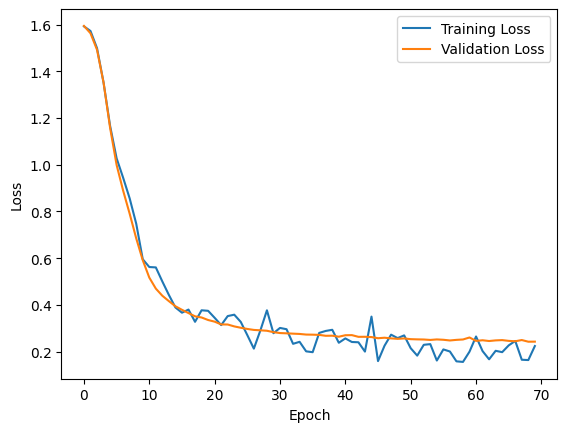

In [ ]:
# Instantiate the model, optimizer, and loss function
model = EMGModel()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
train_losses = []
val_losses = []
# Training loop
for epoch in range(70):
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()  # Reset gradients
        output = model(data)  # Forward pass
        loss = criterion(output, target) # Calculate loss, convert target to long
        loss.backward()  # Backpropagate
        optimizer.step()  # Update weights

    # Validation

    val_loss, val_accuracy = validate(model, test_loader, criterion)
    print(f"Epoch {epoch}: Val Loss = {val_loss:.4f}, Val Accuracy = {val_accuracy:.2f}%")

    # Append losses
    train_losses.append(loss.item()) # Append training loss for current batch
    val_losses.append(val_loss)

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

torch.serialization.add_safe_globals([EMGModel])

In [ ]:
torch.save(model, '/content/drive/MyDrive/EMG hand gestures dataset/model.pth')

In [ ]:
def test_model(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():  # Disable gradient calculation
        for data, target in test_loader:
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == torch.argmax(target, dim=1)).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

In [ ]:
torch.serialization.add_safe_globals([EMGModel, nn.Linear, nn.Tanh, nn.LSTM])

In [ ]:
# Load the saved model
model = torch.load('/content/drive/MyDrive/EMG hand gestures dataset/model.pth')

In [ ]:
test_model(model, test_loader)

Test Accuracy: 90.48%


In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)